In [148]:
from src.data_functions import wrangle
from matplotlib import rcParams
import matplotlib.ticker as ticker
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Georgia']
w = wrangle()
pat = pd.read_csv('data/patient_int.csv')
appt = pd.read_csv('data/interm/appt_cleaned.csv', low_memory=False)

In [149]:
freq = appt.merge(pat)
w.todate(freq, ['Birthdate', 'AptDateTime', 'DateFirstVisit', ])
freq['AptDateTime'] = freq.AptDateTime.dt.date
freq['AptDateTime'] = pd.to_datetime(freq['AptDateTime'])
w.downcast(freq)

### Build Frequency Table for Kmeans

In [150]:
freqs = freq.loc[:, ['PatNum', 'AptDateTime']]
frequency = freqs.groupby('PatNum')['AptDateTime'].count().to_frame().reset_index()

In [151]:
frequency.rename(columns={'AptDateTime':'Frequency'}, inplace=True)
frequency.sort_values('Frequency')

,PatNum,Frequency
5753,8549,1
5506,8220,1
3881,6215,1
3021,5155,1
3023,5159,1
...,...,...
963,2531,92
1812,3572,92
925,2483,107
2786,4843,113


### Frequency Distribution

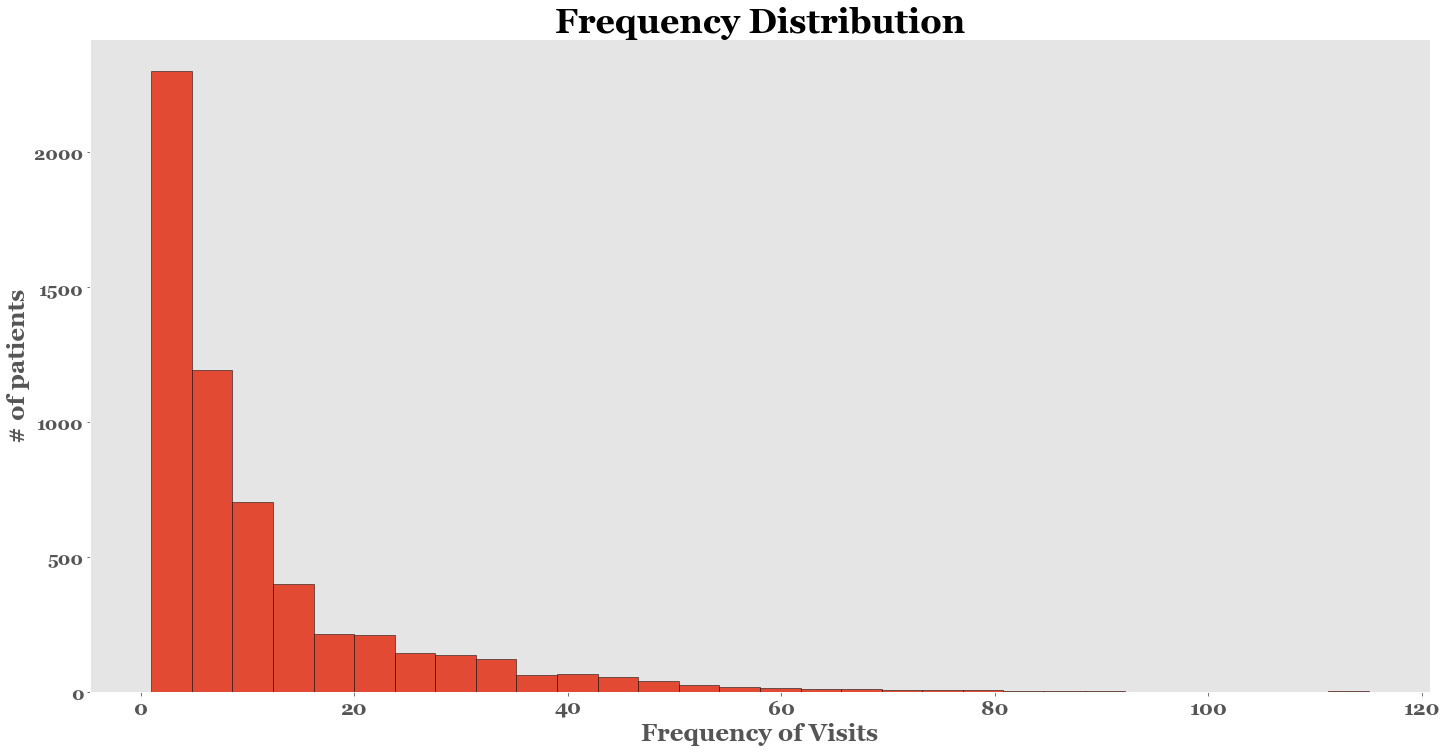

In [159]:
fig = plt.figure(figsize=(24, 12))
plt.style.use('ggplot')

plot = frequency['Frequency'].hist(bins=30, edgecolor='black')
title = plt.title('Frequency Distribution', fontweight='bold', fontsize=34)
xticks = plt.xticks(fontweight='bold', fontsize=20)
yticks = plt.yticks(fontweight='bold', fontsize=18)
xlabel = plt.xlabel('Frequency of Visits', fontweight='bold', fontsize = 24)
ylabel = plt.ylabel('# of patients',  fontweight='bold', fontsize = 24)
plt.grid(False)

In [252]:
date_range = freqs.pivot_table(values='AptDateTime', index='PatNum', aggfunc=['min', 'max'])
tenure = (date_range.iloc[:, 1] - date_range.iloc[:, 0]).dt.days/365
tenure = tenure.to_frame(name='tenure').reset_index().merge(frequency)

In [253]:
def ufunc(row):
    if row == 0:
        return 1
    else: return row
tenure['tenure'] = tenure['tenure'].apply(ufunc)

In [254]:
tenure['vpy'] = tenure.Frequency/tenure.tenure

In [260]:
loyalists = tenure[tenure.vpy.between(2,4)].sort_values('tenure', ascending=False)

In [261]:
len(loyalists)

1942

In [263]:
loyalists[loyalists['tenure'] > 1]

,PatNum,tenure,Frequency,vpy
6,38,17.931507,46,2.565317
327,1611,17.854795,36,2.016265
643,2112,17.810959,56,3.144132
374,1707,17.791781,70,3.934401
601,2059,17.780822,51,2.868259
...,...,...,...,...
3200,5387,1.019178,4,3.924731
5355,8030,1.019178,3,2.943548
5040,7618,1.016438,3,2.951482
228,1363,1.008219,4,3.967391


In [264]:
tenure.to_csv('data/frequency.csv', index=False)

In [57]:
#appt = pd.read_csv('data/interm/appt_cleaned.csv')
#pat = pd.read_csv('data/interm/patient_cleaned.csv')
pay = pd.read_csv('data/interm/pay_cleaned.csv')

In [17]:
max_dates = appt.groupby('PatNum')['AptDate'].max().to_frame().reset_index()

In [18]:
max_dates.rename(columns={'AptDate':'max_date'}, inplace=True)

In [24]:
pat = pat.merge(max_dates)

In [27]:
pat.drop('DateTStamp', axis=1, inplace=True)

In [38]:
from src.data_functions import wrangle
w = wrangle()

In [39]:
w.todate(pat, ['max_date', 'DateFirstVisit'])

In [42]:
pat['tenure'] = (pat['max_date'] - pat['DateFirstVisit']).dt.days

In [46]:
(pat.tenure/365).describe()

count    5740.000000
mean        3.944168
std         4.784219
min        -4.397260
25%         0.322603
50%         1.910959
75%         5.810274
max        28.945205
Name: tenure, dtype: float64

In [51]:
long = pat[pat.tenure >= 1825]

In [82]:
paymerge = pay.loc[:, ['PayAmt', 'PatNum']]

In [85]:
payments = paymerge[paymerge['PatNum'].isin(long['PatNum'])]

In [134]:
full = pat.merge(paymerge)

In [136]:
full_pay = full.groupby('PatNum')['PayAmt'].sum().to_frame().reset_index()

In [132]:
grouped_pay = payments.groupby('PatNum')['PayAmt'].sum().to_frame().reset_index()

,PatNum,PayAmt
0,3,10216.24
1,14,1605.96
2,16,4053.12
3,25,4301.22
4,26,4611.57
...,...,...
1407,7203,338.00
1408,7224,243.00
1409,7233,1510.10
1410,7282,4951.80


In [95]:
final = grouped_pay.merge(long)

In [101]:
final['years'] = final.tenure/365

final['yearly_avg'] = final['PayAmt']/final['years']

final['yearly_avg'].describe()

In [108]:
drops = final[final['yearly_avg'] == 0].PatNum.tolist()

In [109]:
final = final[~final['PatNum'].isin(drops)]

In [131]:
for x in range(5, 25):
    print(f"${round(final[final['years'] >= x]['yearly_avg'].mean(), 2)}\t t = {x} years")

$281.06	 t = 5 years
$280.21	 t = 6 years
$282.67	 t = 7 years
$283.66	 t = 8 years
$279.79	 t = 9 years
$284.08	 t = 10 years
$282.8	 t = 11 years
$285.02	 t = 12 years
$283.46	 t = 13 years
$290.38	 t = 14 years
$278.28	 t = 15 years
$270.27	 t = 16 years
$296.22	 t = 17 years
$312.5	 t = 18 years
$283.24	 t = 19 years
$293.83	 t = 20 years
$308.5	 t = 21 years
$320.79	 t = 22 years
$402.16	 t = 23 years
$433.32	 t = 24 years


In [138]:
final2 = full_pay.merge(pat)

In [145]:
final2['years'] = final2.tenure/365
final2['yearly_avg'] = final2['PayAmt']/final2['years']
final2['yearly_avg'].describe()

count    3.684000e+03
mean     2.158956e+03
std      1.920629e+04
min      0.000000e+00
25%      1.010866e+02
50%      3.154342e+02
75%      8.904336e+02
max      1.029158e+06
Name: yearly_avg, dtype: float64

In [143]:
drops = final2[final2['years'] <= 0]['PatNum'].tolist()

In [144]:
final2 = final2[~final2['PatNum'].isin(drops)]

In [146]:
for x in range(1, 20):
    print(f"${round(final2[final2['years'] >= x]['yearly_avg'].mean(), 2)}\t t = {x} years")

$369.74	 t = 1 years
$316.64	 t = 2 years
$294.19	 t = 3 years
$283.22	 t = 4 years
$279.47	 t = 5 years
$278.38	 t = 6 years
$280.59	 t = 7 years
$281.25	 t = 8 years
$277.75	 t = 9 years
$281.66	 t = 10 years
$280.02	 t = 11 years
$282.2	 t = 12 years
$280.64	 t = 13 years
$286.61	 t = 14 years
$274.72	 t = 15 years
$267.09	 t = 16 years
$293.34	 t = 17 years
$307.02	 t = 18 years
$283.24	 t = 19 years
